In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
import sklearn.datasets
import tensornetwork as tn
%matplotlib inline

# Routines

## Qubits and unitaries indexing

These are the routines we use to build and train the tree tensor network. For simplicity, we take the number of inputs of the latter to be a power of 2.

The inputs are then indexed by integers $0, 1, \ldots, 2^n - 1$. As for the unitaries, they are indexed by pairs of integers $(k, l)$. We explain the notation taking $n = 3$ (i.e, $8$ inputs) for simplicity. Then:

- The unitary taking as inputs pixels $000b$ and $001b$ is indexed by $(2, 00b)$.
- The unitary taking as inputs pixels $010b$ and $011b$ is indexed by $(2, 01b)$.
- The unitary taking as inputs pixels $100b$ and $101b$ is indexed by $(2, 10b)$.
- The unitary taking as inputs pixels $110b$ and $111b$ is indexed by $(2, 11b)$.
- The unitary taking as inputs the output of $(2, 00b)$ and $(2, 01b)$ is indexed by $(1, 0b)$.
- The unitary taking as inputs the output of $(2, 10b)$ and $(2, 11b)$ is indexed by $(1, 1b)$.
- The unitary taking as inputs the output of $(1, 0b)$ and $(1, 1b)$ is indexed by $(0, 0b)$.

Here is a figure:

<img src="ttn.png" width="500">

## Tensor network building

In [2]:
def ttn_tensornetwork_mapping(inputs, unitaries):
    """
    Builds the tree tensor network giving the classification result (2x2 matrix) of the
    specified input from given unitaries.
    
    Parameters
    ----------
    inputs: dict
        A dictionary mapping each qubit index to the rotation angle (Ry rotation) to be applied to it.
    unitaries: dict
        A dictionary mapping each unitary index to the corresponding 4x4 unitary matrix.
    
    Returns
    -------
    tensornetwork.network_components.Node
        The resulting contracted tensor (i.e the density matrix of the output qubit).
    """
    unitaries_nodes = {}
    inputs_nodes = {}
    # Construct data tensors.
    for input_index, input_angle in inputs.items():
        inputs_nodes[input_index] = tn.Node(np.array([ np.cos(input_angle / 2), np.sin(input_angle / 2) ]))
    # Construct unitary tensors.
    for unitary_index, unitary in unitaries.items():
        unitaries_nodes[unitary_index] = tn.Node(unitary.reshape(2, 2, 2, 2))
    # Wire data and unitary tensors together.
    n_bits = len(f"{max(inputs):b}")
    for input_index in range(0, 2 ** n_bits, 2):
        unitary_node = unitaries_nodes[(n_bits - 1, input_index >> 1)]
        inputs_nodes[input_index][0] ^ unitary_node[0]
        inputs_nodes[input_index + 1][0] ^ unitary_node[1]
    while n_bits >= 2:
        for unitary_index_value in range(0, 2 ** (n_bits - 1), 2):
            unitaries_nodes[(n_bits - 1, unitary_index_value)][2] ^ unitaries_nodes[(n_bits - 2, unitary_index_value >> 1)][0]
            unitaries_nodes[(n_bits - 1, unitary_index_value + 1)][2] ^ unitaries_nodes[(n_bits - 2, unitary_index_value >> 1)][1]
        n_bits -= 1
    # Take partial trace.
    nodes = tn.reachable(unitaries_nodes[(0, 0)])
    nodes_copy_conj = tn.copy(nodes, conjugate=True)
    for original_node in unitaries_nodes.values():
        original_node[3] ^ nodes_copy_conj[0][original_node][3]
    contracted_nodes = tn.reachable(unitaries_nodes[(0, 0)])
    result = tn.contractors.greedy(
        contracted_nodes,
        output_edge_order=[
            unitaries_nodes[(0, 0)][2],
            nodes_copy_conj[0][unitaries_nodes[(0, 0)]][2]
        ]
    )
    return result

## Image encoding

In [3]:
def image_rotation_angles(image):
    """
    Construct the dictionary mapping, for the specified grayscale image, each pixel
    index (i.e, flattened pixel coordinate) to the rotation angle encoding it.
    
    Parameters
    ----------
    image: numpy.array
        A 2D-array of numbers (floats/integers, need not be normalized) representing
        the pixels of the grayscale image.
    
    Returns
    -------
    dict
        The aforementionned dictionary.
    """
    max_intensity = np.max(image)
    n_bits = len(f"{(np.size(image) - 1):b}")
    angles = {}
    tuples = []
    for pixel in range(2 ** n_bits):
        pixel_row = 0
        pixel_col = 0
        for bit in range(n_bits):
            if pixel & (1 << bit):
                if bit % 2 == 0:
                    pixel_row += 1 << int(bit / 2)
                else:
                    pixel_col += 1 << int(bit / 2)
        angles[pixel] = np.pi * image[pixel_row, pixel_col] / max_intensity
    return angles

## Training

In [4]:
def label_probability_evaluate(parameters, data):
    """
    Outputs the binary classification result for a given set of training parameters and data
    instance.
    
    Parameters
    ----------
    parameters: numpy.array
        A flat array specifying all the real parameters of the training circuit. For instance,
        for a 8x8 image, this will contain 1008 parameters.
    data: numpy.array
        A 2D-array of numbers (floats/integers, need not be normalized) representing
        the pixels of the grayscale image.
    
    Returns
    -------
    float
        The probability that the image be labelled "positive".
    """
    unitaries_parameters = [ parameters[i:i + 16] for i in range(0, len(parameters), 16) ]
    unitaries = {}
    merged_bits_number = 0
    merged_bits_value = 0
    for up in unitaries_parameters:
        unitaries[(merged_bits_number, merged_bits_value)] = la.expm(1j * np.array([
            [ up[0], up[1] + 1j * up[2], up[3] + 1j * up[4], up[5] + 1j * up[6] ],
            [ up[1] - 1j * up[2], up[7], up[8] + 1j * up[9], up[10] + 1j * up[11] ],
            [ up[3] - 1j * up[4], up[8] - 1j * up[9], up[12], up[13] + 1j * up[14] ],
            [ up[5] - 1j * up[6], up[10] - 1j * up[11], up[13] - 1j * up[14], up[15] ]
        ]))
        merged_bits_value += 1
        if merged_bits_value >= 2 ** merged_bits_number:
            merged_bits_number += 1
            merged_bits_value = 0
    angles = image_rotation_angles(data)
    return ttn_tensornetwork_mapping(angles, unitaries).tensor[1, 1].real

In [5]:
def sample_loss_evaluate(parameters, label, data, l, eta):
    """
    Evaluate the loss function for one sample.
    
    Parameters
    ----------
    parameters: numpy.array
        A flat array specifying all the real parameters of the training circuit. For instance,
        for a 8x8 image, this will contain 1008 parameters.
    label: bool
        The (binary) label of the sample image.
    data: numpy.array
        A 2D-array of numbers (floats/integers, need not be normalized) representing
        the pixels of the grayscale image.
    l: float
        The lambda parameter from https://doi.org/10.1088/2058-9565/aaea94.
    eta: float
        The eta parameter from https://doi.org/10.1088/2058-9565/aaea94.
    
    Returns
    -------
    float
        The loss function for the sample.
    """
    p_label = label_probability_evaluate(parameters, data)
    return max((1 - 2 * p_label + l) if label else (2 * p_label - 1 + l), 0) ** eta

In [6]:
def batch_loss_evaluate(parameters, instances, l, eta, n_samples):
    """
    Evaluate the mini-batch loss.
    
    Parameters
    ----------
    parameters: numpy.array
        A flat array specifying all the real parameters of the training circuit. For instance,
        for a 8x8 image, this will contain 1008 parameters.
    instances: dict
        A dictionary representing the training instances from which one may choose at random.
        The 'images' key maps to an array whose each element is a 2D-array representing an
        image. The 'target' key maps to an array whose elements give the corresponding
        binary labels.
    l: float
        The lambda parameter from https://doi.org/10.1088/2058-9565/aaea94.
    eta: float
        The eta parameter from https://doi.org/10.1088/2058-9565/aaea94.
    n_samples: int
        The n parameter from https://doi.org/10.1088/2058-9565/aaea94.
    
    Returns
    -------
    float
        The mini-batch loss function calculated from n_samples randomly chosen instances.
    """
    sample_indices = np.random.choice(range(len(instances["images"])), n_samples)
    losses = []
    for sample_index in sample_indices:
        losses.append(sample_loss_evaluate(
            parameters,
            instances["target"][sample_index],
            instances["images"][sample_index],
            l,
            eta
        ))
    return np.mean(losses)

In [7]:
def spsa_optimize(instances, l, eta, a, b, A, s, t, gamma, n_samples_per_iter, n_iter):
    """
    Perform the SPSA algorithm on some training instances.
    
    Parameters
    ----------
    instances: dict
        A dictionary representing the training instances from which one may choose at random.
        The 'images' key maps to an array whose each element is a 2D-array representing an
        image. The 'target' key maps to an array whose elements give the corresponding
        binary labels.
    l: float
        The lambda parameter from https://doi.org/10.1088/2058-9565/aaea94.
    eta: float
        The eta parameter from https://doi.org/10.1088/2058-9565/aaea94.
    a: float
        The a parameter from https://doi.org/10.1088/2058-9565/aaea94.
    b: float
        The b parameter from https://doi.org/10.1088/2058-9565/aaea94.
    A: float
        The A parameter from https://doi.org/10.1088/2058-9565/aaea94.
    s: float
        The s parameter from https://doi.org/10.1088/2058-9565/aaea94.
    t: float
        The t parameter from https://doi.org/10.1088/2058-9565/aaea94.
    gamma: float
        The gamma parameter from https://doi.org/10.1088/2058-9565/aaea94.
    n_samples_per_iter: int
        The n parameter from https://doi.org/10.1088/2058-9565/aaea94.
    n_iter: int
        The number of optimization iterations.
    
    Returns
    -------
    tuple
        A 3-tuple: the first element gives the optimized training parameters, the second one
        is an array giving the batch losses at each optimization step, the third one is an
        array giving the gradients at each step.
    """
    parameters = np.random.randn(16 * (np.size(instances["images"][0]) - 1))
    v = np.zeros(len(parameters))
    losses = []
    gradients = []
    losses.append(batch_loss_evaluate(parameters, instances, l, eta, n_samples_per_iter))
    for k in range(n_iter):
        print ("iteration {}/{}".format(k + 1, n_iter))
        delta = 2 * np.random.randint(0, 2, len(parameters)) - 1
        alpha = a / (k + 1 + A) ** s
        beta = b / (k + 1) ** t
        print ("(alpha, beta) = ({}, {})".format(alpha, beta))
        g = (batch_loss_evaluate(parameters + alpha * delta, instances, l, eta, n_samples_per_iter) - batch_loss_evaluate(parameters - alpha * delta, instances, l, eta, n_samples_per_iter)) / (2 * alpha)
        gradients.append(g)
        print ("g = {}".format(g))
        v = gamma * v - g * beta * delta
        parameters += v
        losses.append(batch_loss_evaluate(parameters, instances, l, eta, n_samples_per_iter))
    return parameters, losses, gradients

# Testing

We attempt a test on an MNIST-like dataset provided by `sklearn`.

First, define the classes (i.e, digits) to discriminate between.

In [9]:
negative_class = 1
positive_class = 7

Generate training and testing instances.

In [10]:
# Load a set of 8x8 MNIST-like images.
instances= sklearn.datasets.load_digits(n_class=10)
# Keep only those in the right classes.
selected_indices = np.argwhere((instances["target"] == negative_class) | (instances["target"] == positive_class))[:, -1]
# Take 3/4 of the samples in the training set, keep 1/4 for testing. Fix the labels so that they
# be binary (negative_class -> False, positive_class -> True).
training_indices = selected_indices[:int(3 * len(selected_indices) / 4)]
testing_indices = selected_indices[int(3 * len(selected_indices) / 4):]
training_instances = {}
training_instances["images"] = instances["images"][training_indices]
training_instances["target"] = instances["target"][training_indices]
training_instances["target"] = np.vectorize(lambda label: ({ negative_class: False, positive_class: True })[label])(training_instances["target"])
testing_instances = {}
testing_instances["images"] = instances["images"][testing_indices]
testing_instances["target"] = instances["target"][testing_indices]
testing_instances["target"] = np.vectorize(lambda label: ({ negative_class: False, positive_class: True })[label])(testing_instances["target"])

Run the optimization

In [11]:
parameters, losses, gradients = spsa_optimize(
    training_instances,
    l=0.234,
    eta=5.59,
    a=28.0,
    b=33.0,
    A=74.1,
    s=4.13,
    t=0.658,
    gamma=0.882,
    n_samples_per_iter=30,
    n_iter=30
)

iteration 1/30
(alpha, beta) = (5.020709475071508e-07, 33.0)
g = -33.69009353466768
iteration 2/30
(alpha, beta) = (4.753783499650904e-07, 20.913956613568004)
g = -118.23695381487427
iteration 3/30
(alpha, beta) = (4.504259985341955e-07, 16.016519774881257)
g = -141.6664318890792
iteration 4/30
(alpha, beta) = (4.2708002692270547e-07, 13.254350946491058)
g = -128.23958477559214
iteration 5/30
(alpha, beta) = (4.05218397280514e-07, 11.444364381581925)
g = 1391.5571787071824
iteration 6/30
(alpha, beta) = (3.847297230842114e-07, 10.150569687036988)
g = -335.92403510692145
iteration 7/30
(alpha, beta) = (3.6551222197628706e-07, 9.171480131028975)
g = 121.06800422271681
iteration 8/30
(alpha, beta) = (3.47472782830836e-07, 8.400027898058122)
g = -93.3917580628971
iteration 9/30
(alpha, beta) = (3.305261333846829e-07, 7.773603203004919)
g = 154.83274906617913
iteration 10/30
(alpha, beta) = (3.145940965469299e-07, 7.252937580189922)
g = -258.8943691259501
iteration 11/30
(alpha, beta) = (2.

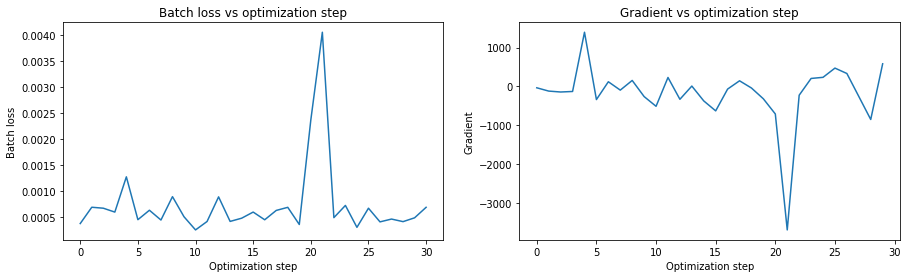

In [12]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
axs[0].plot(losses)
axs[0].set_title("Batch loss vs optimization step")
axs[0].set_xlabel("Optimization step")
axs[0].set_ylabel("Batch loss")
axs[1].plot(gradients)
axs[1].set_title("Gradient vs optimization step")
axs[1].set_xlabel("Optimization step")
axs[1].set_ylabel("Gradient")
plt.show()